Лабораторная работа № 8 по Нейроинформатике

Динамические сети

Выполнила: Тимофеева Наталья М8О-408Б-19

Вариант № 16

In [188]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
from collections import deque

Создадим класс слоя с временной задержкой

In [189]:
class TDL(nn.Module):
    def __init__(self, in_features, delays=1):
        super(TDL, self).__init__()
        self.in_features = in_features
        self.delays = delays
        self.deque = deque()
        self.clear()
    def clear(self):
        self.deque.clear()
        for i in range(self.delays):
            self.deque.append(torch.zeros(self.in_features))
    def push(self, inputs):
        self.deque.appendleft(inputs)
    def forward(self, inputs=0):
        return self.deque.pop()

Создадим класс для NARX (нелинейная авторегрессионная сеть с внешними входами)

In [190]:
class NARX(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, delay1, delay2):
        super(NARX, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.deque1 = TDL(in_features, delay1)
        self.deque2 = TDL(out_features, delay2)
        self.w1 = torch.nn.Parameter(torch.randn(in_features, hidden_features))
        self.w2 = torch.nn.Parameter(torch.randn(hidden_features, out_features))
        self.w3 = torch.nn.Parameter(torch.randn(out_features, hidden_features))
        self.b1 = torch.nn.Parameter(torch.ones(hidden_features))
        self.b2 = torch.nn.Parameter(torch.ones(out_features))
    def forward(self, inputs):
        out1 = torch.tanh(self.deque1() @ self.w1 + self.deque2() @ self.w3 + self.b1)
        out2 = out1 @ self.w2 + self.b2
        self.deque1.push(torch.tensor(inputs))
        self.deque2.push(torch.tensor(out2))
        return out2
    def clear(self):
        self.deque1.clear()
        self.deque2.clear()

Параметры модели

In [191]:
epochs = 200
n = 600
w = 5

Зададим управляющий и идеальный сигналы

In [192]:
t = np.linspace(0, 5, n)
ut = np.cos(t ** 2 - 15 * t + 3) - np.cos(t)

In [193]:
yt = [0]
for i in range(n - 1):
    yt += [yt[-1] / (1 + yt[-1] ** 2) + ut[i] ** 3]

In [194]:
train_data = [(np.array(ut[i:i + w], dtype=np.float32),
               np.array(yt[i:i + w], dtype=np.float32)) for i in range(n - w)]
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=False)

Создаём модель

In [195]:
model = NARX(5, 10, 5, 3, 3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Обучаем

In [196]:
model.train()

NARX(
  (deque1): TDL()
  (deque2): TDL()
)

In [197]:
train_loss = []
start_time = timer()
for i in range(epochs):
    pbar = tqdm(enumerate(train_loader))
    #model.clear()
    loss_per_epoch = []
    for _, (inputs, given_outputs) in pbar:
        outputs = model(inputs)
        crit = nn.MSELoss()
        loss = crit(given_outputs, outputs)
        loss_per_epoch += [loss.item()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss += [np.mean(loss_per_epoch)]
    pbar.write('%d. loss = %f ' % (i + 1, train_loss[-1]))
end_time = timer()

0it [00:00, ?it/s]C:\Users\volch\AppData\Local\Temp\ipykernel_5012\2841970211.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.deque1.push(torch.tensor(inputs))
C:\Users\volch\AppData\Local\Temp\ipykernel_5012\2841970211.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.deque2.push(torch.tensor(out2))
595it [00:00, 1375.54it/s]


1. loss = 10.126014 


595it [00:00, 1431.42it/s]


2. loss = 6.405377 


595it [00:00, 1426.75it/s]


3. loss = 4.247128 


595it [00:00, 1433.32it/s]


4. loss = 3.154549 


595it [00:00, 1427.56it/s]


5. loss = 2.760195 


595it [00:00, 1431.74it/s]


6. loss = 2.479308 


595it [00:00, 1437.42it/s]


7. loss = 2.161671 


595it [00:00, 1439.00it/s]


8. loss = 2.174271 


595it [00:00, 1442.35it/s]


9. loss = 1.786616 


595it [00:00, 1432.92it/s]


10. loss = 1.668497 


595it [00:00, 1421.34it/s]


11. loss = 1.709817 


595it [00:00, 1396.91it/s]


12. loss = 1.535436 


595it [00:00, 1437.26it/s]


13. loss = 1.630287 


595it [00:00, 1421.65it/s]


14. loss = 1.743165 


595it [00:00, 1427.22it/s]


15. loss = 1.729573 


595it [00:00, 1432.27it/s]


16. loss = 1.600381 


595it [00:00, 1425.43it/s]


17. loss = 1.774336 


595it [00:00, 1446.71it/s]


18. loss = 1.370347 


595it [00:00, 1432.95it/s]


19. loss = 1.279798 


595it [00:00, 1432.10it/s]


20. loss = 1.292278 


595it [00:00, 1439.48it/s]


21. loss = 1.182380 


595it [00:00, 1430.45it/s]


22. loss = 1.108096 


595it [00:00, 1429.82it/s]


23. loss = 1.118440 


595it [00:00, 1453.52it/s]


24. loss = 0.936224 


595it [00:00, 1433.87it/s]


25. loss = 1.023491 


595it [00:00, 1440.76it/s]


26. loss = 1.047860 


595it [00:00, 1426.42it/s]


27. loss = 0.940208 


595it [00:00, 1441.05it/s]


28. loss = 0.977149 


595it [00:00, 1433.11it/s]


29. loss = 0.986639 


595it [00:00, 1444.73it/s]


30. loss = 1.053385 


595it [00:00, 1440.12it/s]


31. loss = 1.051814 


595it [00:00, 1442.83it/s]


32. loss = 1.030685 


595it [00:00, 1452.76it/s]


33. loss = 1.013026 


595it [00:00, 1442.76it/s]


34. loss = 0.940240 


595it [00:00, 1445.78it/s]


35. loss = 0.882799 


595it [00:00, 1426.08it/s]


36. loss = 0.899881 


595it [00:00, 1444.94it/s]


37. loss = 0.832506 


595it [00:00, 1435.48it/s]


38. loss = 0.818019 


595it [00:00, 1444.26it/s]


39. loss = 0.792344 


595it [00:00, 1462.64it/s]


40. loss = 0.742686 


595it [00:00, 1433.33it/s]


41. loss = 0.753732 


595it [00:00, 1445.21it/s]


42. loss = 0.710376 


595it [00:00, 1449.80it/s]


43. loss = 0.693317 


595it [00:00, 1436.41it/s]


44. loss = 0.678962 


595it [00:00, 1448.08it/s]


45. loss = 0.717800 


595it [00:00, 1445.45it/s]


46. loss = 0.601143 


595it [00:00, 1453.57it/s]


47. loss = 0.620551 


595it [00:00, 1456.32it/s]


48. loss = 0.643751 


595it [00:00, 1435.48it/s]


49. loss = 0.598219 


595it [00:00, 1446.93it/s]


50. loss = 0.587942 


595it [00:00, 1438.79it/s]


51. loss = 0.578667 


595it [00:00, 1447.45it/s]


52. loss = 0.578387 


595it [00:00, 1446.74it/s]


53. loss = 0.550301 


595it [00:00, 1455.22it/s]


54. loss = 0.565554 


595it [00:00, 1444.62it/s]


55. loss = 0.543771 


595it [00:00, 1444.37it/s]


56. loss = 0.523524 


595it [00:00, 1445.11it/s]


57. loss = 0.518379 


595it [00:00, 1443.76it/s]


58. loss = 0.513059 


595it [00:00, 1421.64it/s]


59. loss = 0.502928 


595it [00:00, 1418.87it/s]


60. loss = 0.491748 


595it [00:00, 1439.60it/s]


61. loss = 0.467623 


595it [00:00, 1448.35it/s]


62. loss = 0.468435 


595it [00:00, 1445.42it/s]


63. loss = 0.464246 


595it [00:00, 1454.25it/s]


64. loss = 0.463490 


595it [00:00, 1430.42it/s]


65. loss = 0.457314 


595it [00:00, 1443.28it/s]


66. loss = 0.452185 


595it [00:00, 1447.23it/s]


67. loss = 0.443755 


595it [00:00, 1445.28it/s]


68. loss = 0.435647 


595it [00:00, 1443.48it/s]


69. loss = 0.428068 


595it [00:00, 1439.03it/s]


70. loss = 0.420788 


595it [00:00, 1445.48it/s]


71. loss = 0.413721 


595it [00:00, 1460.20it/s]


72. loss = 0.406513 


595it [00:00, 1442.77it/s]


73. loss = 0.399040 


595it [00:00, 1444.97it/s]


74. loss = 0.391951 


595it [00:00, 1456.72it/s]


75. loss = 0.385554 


595it [00:00, 1435.00it/s]


76. loss = 0.379742 


595it [00:00, 1443.46it/s]


77. loss = 0.374996 


595it [00:00, 1442.53it/s]


78. loss = 0.370609 


595it [00:00, 1447.55it/s]


79. loss = 0.365966 


595it [00:00, 1453.33it/s]


80. loss = 0.360876 


595it [00:00, 1452.74it/s]


81. loss = 0.355497 


595it [00:00, 1449.91it/s]


82. loss = 0.350227 


595it [00:00, 1443.28it/s]


83. loss = 0.345443 


595it [00:00, 1444.66it/s]


84. loss = 0.341321 


595it [00:00, 1446.64it/s]


85. loss = 0.337837 


595it [00:00, 1438.12it/s]


86. loss = 0.334837 


595it [00:00, 1449.28it/s]


87. loss = 0.332063 


595it [00:00, 1439.30it/s]


88. loss = 0.329220 


595it [00:00, 1436.29it/s]


89. loss = 0.326131 


595it [00:00, 1444.49it/s]


90. loss = 0.322838 


595it [00:00, 1434.00it/s]


91. loss = 0.319631 


595it [00:00, 1442.76it/s]


92. loss = 0.316743 


595it [00:00, 1460.20it/s]


93. loss = 0.314088 


595it [00:00, 1436.77it/s]


94. loss = 0.311299 


595it [00:00, 1445.40it/s]


95. loss = 0.308181 


595it [00:00, 1450.96it/s]


96. loss = 0.305032 


595it [00:00, 1435.49it/s]


97. loss = 0.302472 


595it [00:00, 1443.16it/s]


98. loss = 0.300764 


595it [00:00, 1435.95it/s]


99. loss = 0.299122 


595it [00:00, 1452.89it/s]


100. loss = 0.296436 


595it [00:00, 1444.63it/s]


101. loss = 0.292136 


595it [00:00, 1457.32it/s]


102. loss = 0.286436 


595it [00:00, 1429.67it/s]


103. loss = 0.280150 


595it [00:00, 1466.51it/s]


104. loss = 0.274600 


595it [00:00, 1440.94it/s]


105. loss = 0.271094 


595it [00:00, 1449.17it/s]


106. loss = 0.270220 


595it [00:00, 1418.54it/s]


107. loss = 0.270262 


595it [00:00, 1421.41it/s]


108. loss = 0.272679 


595it [00:00, 1448.58it/s]


109. loss = 0.288829 


595it [00:00, 1443.60it/s]


110. loss = 0.329095 


595it [00:00, 1458.83it/s]


111. loss = 0.344066 


595it [00:00, 1443.43it/s]


112. loss = 0.314018 


595it [00:00, 1445.94it/s]


113. loss = 0.276153 


595it [00:00, 1450.25it/s]


114. loss = 0.266861 


595it [00:00, 1429.88it/s]


115. loss = 0.264573 


595it [00:00, 1444.16it/s]


116. loss = 0.268092 


595it [00:00, 1444.08it/s]


117. loss = 0.270422 


595it [00:00, 1452.56it/s]


118. loss = 0.273680 


595it [00:00, 1459.77it/s]


119. loss = 0.274282 


595it [00:00, 1460.22it/s]


120. loss = 0.274388 


595it [00:00, 1442.16it/s]


121. loss = 0.268124 


595it [00:00, 1422.87it/s]


122. loss = 0.269410 


595it [00:00, 1447.09it/s]


123. loss = 0.266370 


595it [00:00, 1431.41it/s]


124. loss = 0.271464 


595it [00:00, 1447.04it/s]


125. loss = 0.258507 


595it [00:00, 1440.38it/s]


126. loss = 0.268037 


595it [00:00, 1453.06it/s]


127. loss = 0.246643 


595it [00:00, 1439.86it/s]


128. loss = 0.257732 


595it [00:00, 1455.71it/s]


129. loss = 0.232777 


595it [00:00, 1440.06it/s]


130. loss = 0.243915 


595it [00:00, 1452.50it/s]


131. loss = 0.217265 


595it [00:00, 1442.16it/s]


132. loss = 0.235778 


595it [00:00, 1444.10it/s]


133. loss = 0.209310 


595it [00:00, 1442.49it/s]


134. loss = 0.243735 


595it [00:00, 1439.87it/s]


135. loss = 0.207337 


595it [00:00, 1445.69it/s]


136. loss = 0.238532 


595it [00:00, 1447.73it/s]


137. loss = 0.209820 


595it [00:00, 1451.35it/s]


138. loss = 0.237038 


595it [00:00, 1448.28it/s]


139. loss = 0.205297 


595it [00:00, 1430.05it/s]


140. loss = 0.228404 


595it [00:00, 1441.02it/s]


141. loss = 0.211902 


595it [00:00, 1438.17it/s]


142. loss = 0.228456 


595it [00:00, 1449.70it/s]


143. loss = 0.204086 


595it [00:00, 1452.28it/s]


144. loss = 0.215419 


595it [00:00, 1442.89it/s]


145. loss = 0.219498 


595it [00:00, 1447.61it/s]


146. loss = 0.214190 


595it [00:00, 1443.13it/s]


147. loss = 0.206538 


595it [00:00, 1447.95it/s]


148. loss = 0.208043 


595it [00:00, 1444.48it/s]


149. loss = 0.207606 


595it [00:00, 1431.88it/s]


150. loss = 0.208671 


595it [00:00, 1455.74it/s]


151. loss = 0.205331 


595it [00:00, 1449.14it/s]


152. loss = 0.206893 


595it [00:00, 1430.21it/s]


153. loss = 0.202990 


595it [00:00, 1433.32it/s]


154. loss = 0.207107 


595it [00:00, 1436.53it/s]


155. loss = 0.196437 


595it [00:00, 1422.53it/s]


156. loss = 0.211698 


595it [00:00, 1421.73it/s]


157. loss = 0.191082 


595it [00:00, 1436.48it/s]


158. loss = 0.214614 


595it [00:00, 1447.19it/s]


159. loss = 0.193516 


595it [00:00, 1436.62it/s]


160. loss = 0.218641 


595it [00:00, 1445.67it/s]


161. loss = 0.191112 


595it [00:00, 1447.23it/s]


162. loss = 0.211363 


595it [00:00, 1442.54it/s]


163. loss = 0.203206 


595it [00:00, 1452.69it/s]


164. loss = 0.197787 


595it [00:00, 1437.03it/s]


165. loss = 0.198272 


595it [00:00, 1448.67it/s]


166. loss = 0.192917 


595it [00:00, 1445.48it/s]


167. loss = 0.205881 


595it [00:00, 1450.68it/s]


168. loss = 0.187253 


595it [00:00, 1437.48it/s]


169. loss = 0.213052 


595it [00:00, 1448.56it/s]


170. loss = 0.188132 


595it [00:00, 1444.57it/s]


171. loss = 0.213710 


595it [00:00, 1450.59it/s]


172. loss = 0.188331 


595it [00:00, 1454.68it/s]


173. loss = 0.209259 


595it [00:00, 1458.37it/s]


174. loss = 0.188208 


595it [00:00, 1441.17it/s]


175. loss = 0.211784 


595it [00:00, 1448.82it/s]


176. loss = 0.188130 


595it [00:00, 1447.74it/s]


177. loss = 0.206827 


595it [00:00, 1440.70it/s]


178. loss = 0.188124 


595it [00:00, 1446.90it/s]


179. loss = 0.210105 


595it [00:00, 1444.24it/s]


180. loss = 0.187953 


595it [00:00, 1444.25it/s]


181. loss = 0.206255 


595it [00:00, 1441.75it/s]


182. loss = 0.187681 


595it [00:00, 1425.55it/s]


183. loss = 0.207856 


595it [00:00, 1434.13it/s]


184. loss = 0.187910 


595it [00:00, 1439.17it/s]


185. loss = 0.204547 


595it [00:00, 1462.28it/s]


186. loss = 0.187847 


595it [00:00, 1444.49it/s]


187. loss = 0.205093 


595it [00:00, 1446.26it/s]


188. loss = 0.187989 


595it [00:00, 1441.97it/s]


189. loss = 0.202763 


595it [00:00, 1434.11it/s]


190. loss = 0.188210 


595it [00:00, 1444.51it/s]


191. loss = 0.201781 


595it [00:00, 1455.26it/s]


192. loss = 0.188466 


595it [00:00, 1446.32it/s]


193. loss = 0.199997 


595it [00:00, 1439.86it/s]


194. loss = 0.188809 


595it [00:00, 1456.55it/s]


195. loss = 0.197154 


595it [00:00, 1453.03it/s]


196. loss = 0.189057 


595it [00:00, 1435.48it/s]


197. loss = 0.193807 


595it [00:00, 1451.50it/s]


198. loss = 0.189796 


595it [00:00, 1451.71it/s]


199. loss = 0.192564 


595it [00:00, 1391.33it/s]

200. loss = 0.192022 


In [198]:
model.eval()

NARX(
  (deque1): TDL()
  (deque2): TDL()
)

In [199]:
#model.clear()

In [200]:
predicted = []
for x, _ in train_data:
    predicted += [model(x).detach().numpy().item(-1)]

C:\Users\volch\AppData\Local\Temp\ipykernel_5012\2841970211.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.deque2.push(torch.tensor(out2))


Выводим результаты

In [201]:
print('Время обучения = {0} секунд'.format(int(end_time - start_time)))
print('Количество эпох = {0}'.format(epochs))

Время обучения = 82 секунд
Количество эпох = 200


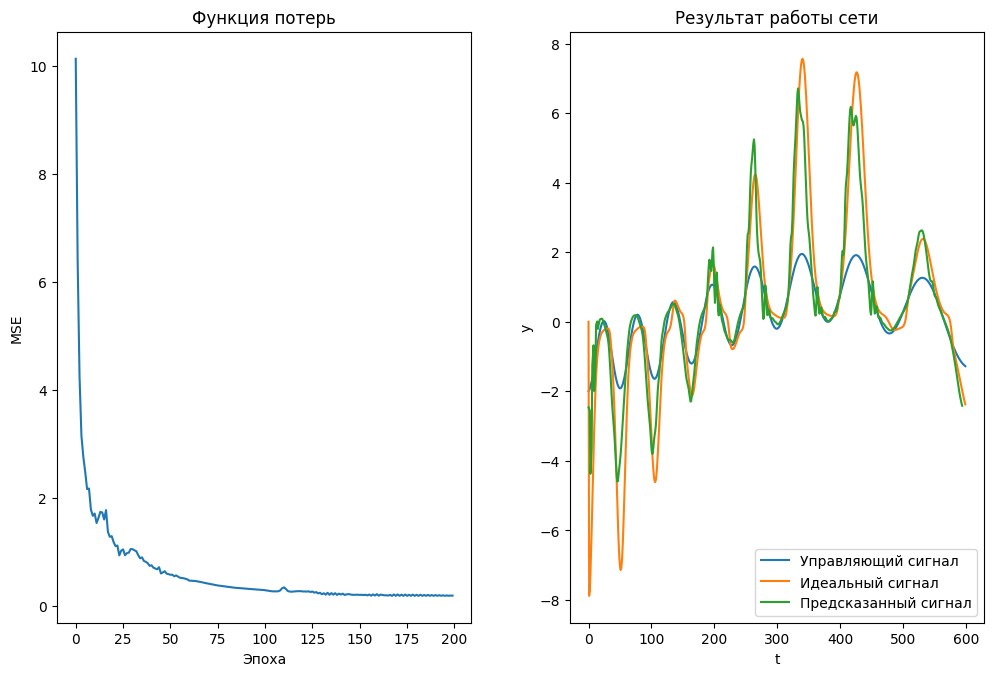

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6.5))
fig.tight_layout(h_pad = 4, w_pad = 4)

axes[0].set_title('Функция потерь')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('MSE')
axes[0].plot(train_loss)

axes[1].set_title('Результат работы сети')
axes[1].set_xlabel('t')
axes[1].set_ylabel('y')
axes[1].plot(ut, label = 'Управляющий сигнал')
axes[1].plot(yt, label = 'Идеальный сигнал')
axes[1].plot(predicted, label = 'Предсказанный сигнал')
axes[1].legend()